In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import jax.numpy as jnp

import multihist as mh
import appletree as apt
from appletree import utils
from appletree import randgen
from appletree import hist
from appletree.context import Context, ERBand

In [2]:
utils.set_gpu_memory_usage(0.2)

# Define context

In [3]:
tree = ERBand()

## show registered plugins in context

In [4]:
tree._plugin_class_registry

{'drift_survive_prob': appletree.plugins.detector.DriftLoss,
 'eff': appletree.plugins.efficiency.Eff,
 'num_electron_drifted': appletree.plugins.detector.ElectronDrifted,
 'energy': appletree.plugins.common.EnergySpectra,
 'num_ion': appletree.plugins.microphys.Ionization,
 'num_s1_phd': appletree.plugins.detector.PhotonDetection,
 'x': appletree.plugins.common.PositionSpectra,
 'y': appletree.plugins.common.PositionSpectra,
 'z': appletree.plugins.common.PositionSpectra,
 'num_quanta': appletree.plugins.microphys.Quenching,
 'recomb_std': appletree.plugins.microphys.RecombFluct,
 'num_photon': appletree.plugins.microphys.Recombination,
 'num_electron': appletree.plugins.microphys.Recombination,
 's1': appletree.plugins.reconstruction.S1,
 's1_correction': appletree.plugins.detector.S1Correction,
 'num_s1_pe': appletree.plugins.detector.S1PE,
 'acc_s1_recon_eff': appletree.plugins.efficiency.S1ReconEff,
 's2': appletree.plugins.reconstruction.S2,
 's2_correction': appletree.plugins.de

## deduce dependency relation network

In [5]:
tree.deduce()

## show worksheet in simulation

In [6]:
tree.worksheet

[['PositionSpectra', ['x', 'y', 'z'], ['batch_size']],
 ['EnergySpectra', ['energy'], ['batch_size']],
 ['RecombFluct', ['recomb_std'], ['energy']],
 ['mTI', ['recomb_mean'], ['energy']],
 ['Quenching', ['num_quanta'], ['energy']],
 ['TrueRecomb', ['recomb'], ['recomb_mean', 'recomb_std']],
 ['Ionization', ['num_ion'], ['num_quanta']],
 ['S1Correction', ['s1_correction'], ['x', 'y', 'z']],
 ['Recombination',
  ['num_photon', 'num_electron'],
  ['num_quanta', 'num_ion', 'recomb']],
 ['PhotonDetection', ['num_s1_phd'], ['num_photon', 's1_correction']],
 ['DriftLoss', ['drift_survive_prob'], ['z']],
 ['S2Correction', ['s2_correction'], ['x', 'y']],
 ['ElectronDrifted',
  ['num_electron_drifted'],
  ['num_electron', 'drift_survive_prob']],
 ['S2PE', ['num_s2_pe'], ['num_electron_drifted', 's2_correction']],
 ['S2', ['s2'], ['num_s2_pe']],
 ['S1ReconEff', ['acc_s1_recon_eff'], ['num_s1_phd']],
 ['S2Threshold', ['acc_s2_threshold'], ['s2']],
 ['S1PE', ['num_s1_pe'], ['num_s1_phd']],
 ['S1', 

## show codes deduced

In [7]:
print(tree.code)

from functools import partial
from jax import jit
from appletree.plugins import PositionSpectra
from appletree.plugins import EnergySpectra
from appletree.plugins import RecombFluct
from appletree.plugins import mTI
from appletree.plugins import Quenching
from appletree.plugins import TrueRecomb
from appletree.plugins import Ionization
from appletree.plugins import S1Correction
from appletree.plugins import Recombination
from appletree.plugins import PhotonDetection
from appletree.plugins import DriftLoss
from appletree.plugins import S2Correction
from appletree.plugins import ElectronDrifted
from appletree.plugins import S2PE
from appletree.plugins import S2
from appletree.plugins import S1ReconEff
from appletree.plugins import S2Threshold
from appletree.plugins import S1PE
from appletree.plugins import S1
from appletree.plugins import Eff
from appletree.plugins import cS2
from appletree.plugins import cS1
PositionSpectra_ = PositionSpectra()
EnergySpectra_ = EnergySpectra()
RecombFlu

# Compilation

In [8]:
tree.compile()

# Simulation

In [9]:
batch_size = int(1e6)
key = randgen.get_key()

key, _ = simulate(key, batch_size, tree.parameters)
      
cs1, cs2, eff = _

## draw histogram and compare with data

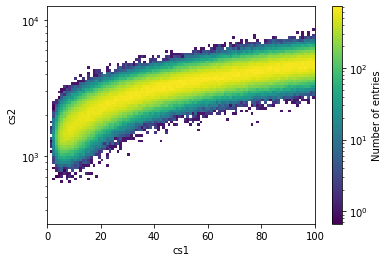

In [10]:
h, be = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T,
    bins=(jnp.linspace(0, 100, 101), jnp.logspace(2.5, 4.1, 81)),
    weights=eff
)

h = mh.Histdd.from_histogram(
    np.array(h), 
    be, 
    axis_names=['cs1', 'cs2']
)
h.plot(norm=LogNorm())
plt.yscale('log')
plt.show()

### read data and binning

In [11]:
data = pd.read_csv('./appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv')
x_bins, y_bins = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[1e2, 1e4]
)

(500.0, 10000.0)

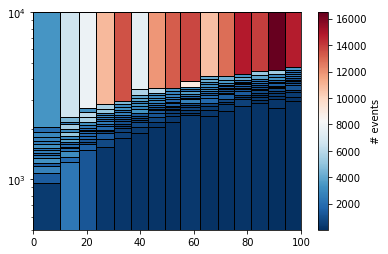

In [12]:
h = hist.make_hist_irreg_bin_2d(jnp.asarray([cs1, cs2]).T, x_bins, y_bins, weights=eff)

apt.utils.plot_irreg_histogram_2d(x_bins, y_bins, h, density=False)
plt.yscale('log')
plt.ylim(5e2, 1e4)

# Speed test

In [13]:
@apt.utils.timeit
def test(key, batch_size, parameters):
    return simulate(key, batch_size, parameters)

In [14]:
test(key, int(1e6), tree.parameters)

@apt.utils.timeit
def benchmark():
    key = randgen.get_key()
    for _ in range(100):
        # tree.init_parameters()
        key, _ = test(key, int(1e6), tree.parameters)

 Function <test> starts. 
 Function <test> ends! Time cost = 4.224777 msec. 


In [15]:
benchmark()

 Function <benchmark> starts. 
 Function <test> starts. 
 Function <test> ends! Time cost = 2.365112 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 2.161264 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 2.332926 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 2.218008 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.000353 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.041838 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.031109 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.014896 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.056381 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.044222 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.039454 msec. 
 Function <test> starts. 
 Function <test> ends! Time cost = 5.040407 msec. 
 Function <test> starts. 
 Function <test> en